# 03. Machine learning

This session will cover a range of approaches to supervised and unsupervised machine learning for textual data. By the time we're through, we'll have built and evaluated a simple model that attempts to predict the author nationality of a small test set of novels on the basis of word features observed in our toy corpus.

Some of the code in this notebook is based on work by Stéfan Sinclair and the [Trace of Theory](https://github.com/htrc/ACS-TT) project.

## What's the difference between supervised and unsupervised learning?

The fundamental difference is that in **supervised** learning, you know in advance the categories you're trying to predict, while in **unsupervised** learning, you're trying to find similarities between items in your corpus, but don't know the identity of the bins into which they should be sorted.

Another way to think about this is that in **supervised** learning, you're able to supply labeled training data. Examples include a set of detective novels, if you're trying to classify a corpus into detective and non-detective fiction, or a set of British and American novels, if you want to try to sort out those two classes. In **unsupervised** learning, you don't need to supply any training data; you're looking for "natural" groupings within the data based on features you identify.

It's sometimes said that **unsupervised** methods are exploratory, while **supervised** methods are ... non-exploratory? ... serious? I'm not sure. This is true in the sense that **unsupervised** methods can often give you a sense of the structure of your data and can help guide you toward commonalities that you would not otherwise have known about. **Supervised** methods generally require both a stronger sense of what's in your data set and a larger investment of time at the front end of the process, because you have to generate training data. On the other hand, it's really easy to evaluate the output and performance of a supervised model -- you just run it over some held-out, labeled test data and see how it did.

Evaluating gthe performance of **unsupervised** methods is more complicated, since the whole point is that you don't know in advance what the right answers should be. So, while they're easier to get off the ground, you generally spend more time trying to figure out how well they worked.

You should use the method appropriate to your research problem. One of the most well-known learning techniques in textual analysis -- LDA topic modeling -- is unsupervised. NER and part of speech tagging are supervised methods. We'll examine both types of learning below.

## LDA and word vectors

Two unsupervised methods that have gotten a lot of attention from humanists in recent years are topic models and word vector embeddings. They have a lot in common. You can think of them as attempts to perform semantic dimensionality reduction. That is, they're ways to move from complex full-text documents to a reduced set of word clusters that are themselves "meaningful" and that capture as much of the information in the source documents as possible.

**Topic models** assign every word in every corpus document to one of a fixed number of buckets, though the identity of the buckets isn't known in advance. The process is mathematically complex, but the idea is that you observe the distribution of words in the corpus, then attempt to solve for the word-buckets from which an author would have drawn in order to produce the observed distribution. The output is a set of "topics" (the buckets, containing occurrence-weighted lists of words) that really do hold together surprisingly well in conceptual terms, especially when you pre-process the corpus is appropriate ways (on which, more in class).

There are several topic modeling packages available. In pure Python, the [Gensim](https://radimrehurek.com/gensim/) package is the one to use. Most people, however, prefer [MALLET](http://mallet.cs.umass.edu), a Java-based general-purpose NLP toolkit that happens to specialize in topic models.

**Word vector embeddings** have become popular more recently, driven in large part by Google's [word2vec](https://code.google.com/archive/p/word2vec/) neural-network vector embedding package. (Note that `word2vec` is also supported in Gensim.) Word vectors attempt to map words in a corpus to vectors in a relatively low-dimensional space (100-300 dimensions are common) such that words that co-occur at the sentence (or other text unit) level have similar vectors. That is, such that they "point" in similar directions. It's possible then, to query the model for the words whose vectors are most closely aligned with a target word.

All of this sounds kind of basic and dull, except that the model produces some nifty results. Trained on contemporary news text, for example, we can see that "San Francisco" is most similar to "Los Angeles," "Golden Gate," and "Oakland." And we can do things that look like analogies by adding and subtracting vectors: Paris - France + Italy = Rome; king - man + woman = queen.

Finally, we can use a second unsupervised method to cluster the output vectors into similarity groups, which then function much like modeled topics: groups of words that resemble one another in semantically coherent ways.

## What we'll do

Topic models and word vectors are fine, and you may want to use them in your own work. But I'd like to show some approaches that are somewhat simpler and that help to illustrate the processes involved in supervised and unsupervised learning. So we'll once again spend some time with our little literary corpus and, now, a package called [scikit-learn](http://scikit-learn.org/stable/), the standard machine learning library in Python. `scikit-learn` is included with Anaconda, so there's nothing new to download, though we will, of course, need to import it as appropriate.

## Recreate the corpus

In [37]:
# Suppress compatibility warnings
import warnings
warnings.filterwarnings('ignore')

In [38]:
import pandas as pd
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

text_dir = '../Data/Texts/'
corpus = PlaintextCorpusReader(text_dir, '.*\.txt')

# A function to turn fileids into a table of metadata
def parse_fileids(fileids):
    '''Takes a list of file names formatted like A-Cather-Antonia-1918-F.txt.
       Returns a pandas dataframe of derived metadata.'''
    import pandas as pd
    meta = {}
    for fileid in fileids:
        file = fileid.strip('.txt') # Get rid of file suffix
        fields = file.split('-') # Split on dashes
        fields[2] = fields[2].replace('_', ' ') # Remove underscore from titles
        fields[3] = int(fields[3])
        meta[file] = fields
    metadata = pd.DataFrame.from_dict(meta, orient='index') # Build dataframe
    metadata.columns = ['nation', 'author', 'title', 'pubdate', 'gender'] # Col names
    return metadata.sort_index() # Note we need to sort b/c datframe built from dictionary

def collect_stats(corpus):
    '''Takes an NLTK corpus as input. 
       Returns a pandas dataframe of stats indexed to fileid.'''
    import nltk
    import pandas as pd
    stats = {}
    for fileid in corpus.fileids():
        word_count = len(corpus.words(fileid))
        stats[fileid.strip('.txt')] = {'wordcount':word_count}
    statistics = pd.DataFrame.from_dict(stats, orient='index')
    return statistics.sort_index()

books = parse_fileids(corpus.fileids())
stats = collect_stats(corpus)
books = books.join(stats)
books.index.set_names('file', inplace=True)
books.head()

,nation,author,title,pubdate,gender,wordcount
file,,,,,,
A-Cather-Antonia-1918-F,A,Cather,Antonia,1918,F,97574
A-Chesnutt-Marrow-1901-M,A,Chesnutt,Marrow,1901,M,110288
A-Crane-Maggie-1893-M,A,Crane,Maggie,1893,M,28628
A-Davis-Life_Iron_Mills-1861-F,A,Davis,Life Iron Mills,1861,F,18789
A-Dreiser-Sister_Carrie-1900-M,A,Dreiser,Sister Carrie,1900,M,194062


## Unsupervised clustering

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram

%matplotlib inline

# Plot the documents from the corpus
def plot_corpus_similarity(corpus, vectorizer):
    '''Function to create two plots of corpus similarity.
       Takes an NLTK corpus and an SK-learn vectorizer as input.
       Creates a matplotlib plot with Ward dendrogram and 2D spatial plot.
       Returns nothing.'''
    
    # Generate vectors, distances and positions
    texts = [corpus.raw(fileid) for fileid in corpus.fileids()]
    documentTermMatrix = vectorizer.fit_transform(texts)
    distances = 1 - cosine_similarity(documentTermMatrix)
    mds = MDS(dissimilarity="precomputed", random_state=1)
    positions = mds.fit_transform(distances)
    
    # Plot dendrogram
    linkage_matrix = ward(distances)
    plt.figure(figsize=(8,10))
    dendrogram(linkage_matrix, labels=corpus.fileids(), orientation="right");
    plt.show()
    
    # Plot scatter
    xvalues = positions[:, 0] 
    yvalues = positions[: ,1] 
    plt.figure(figsize=(20,10))
    for x, y, name in zip(xvalues, yvalues, corpus.fileids()):
        plt.scatter(x, y)
        plt.text(x, y, name.replace(".txt", "")[:25], 
                 color='red' if 'A-' in name else 'blue')
    plt.show()

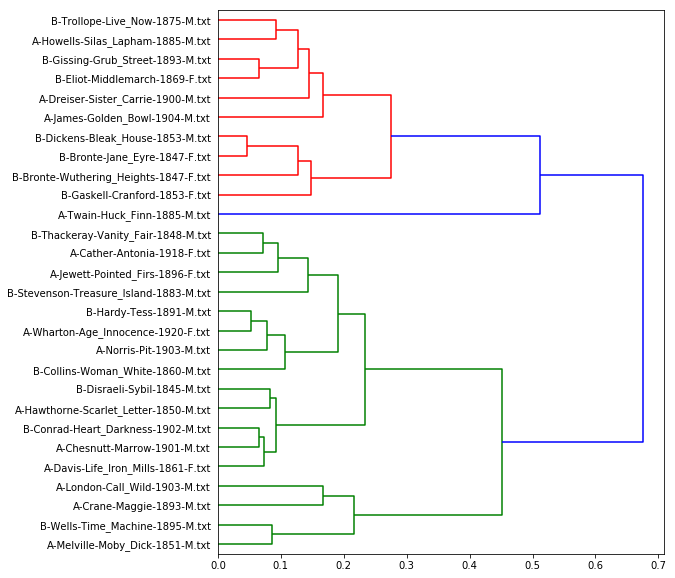

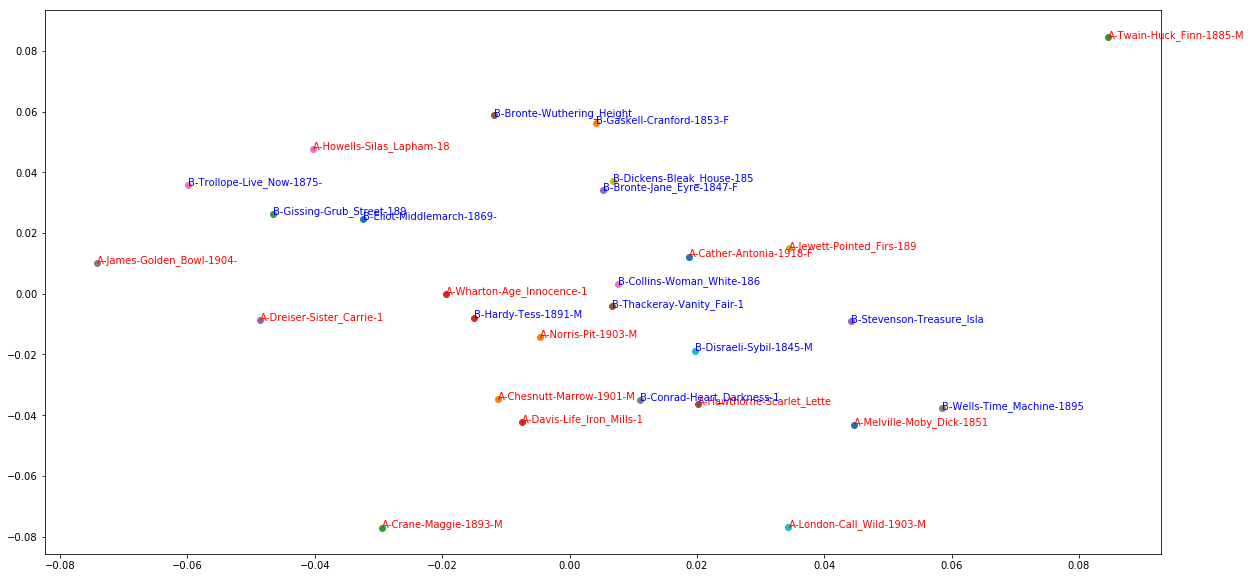

In [31]:
simple_vectorizer = TfidfVectorizer(use_idf=False)
plot_corpus_similarity(corpus, simple_vectorizer)

Now try the same plot, but with stopwords removed. Stopwords are common words that are not generally meaningful on their own ("the," "in," "a," etc.). Removing them allows us to compare the semantic content of the books more directly.

If the code below complains about missing the NLTK stopword list, run this line of code **from the command line** to download it:

> `python -m nltk.downloader stopwords`

But don't worry about thr NLTK list too much. It's good for non-fiction, but doesn't include common names. That's fine in the general case, but a problem in fiction, where the 'George' in one book is unlikely to be the same 'George' as the one in another book. We'll work, therefore, with an expanded stopword list created by Ted Underwood and Andrew Goldstone for literary purposes.

In [39]:
# NLTK stopwords
stopwords = nltk.corpus.stopwords.words("english")

In [40]:
# Underwood-Goldstone stopwords
stopwords_better = [word.strip() for word in open('../Data/stopwords-underwood-goldstone.txt')]
stopwords_better[100:105]

['however', 'has', 'up', 'did', 'within']

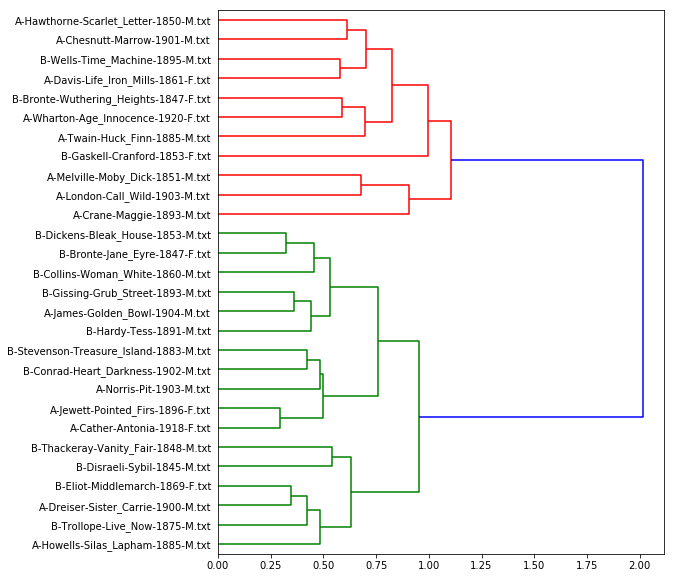

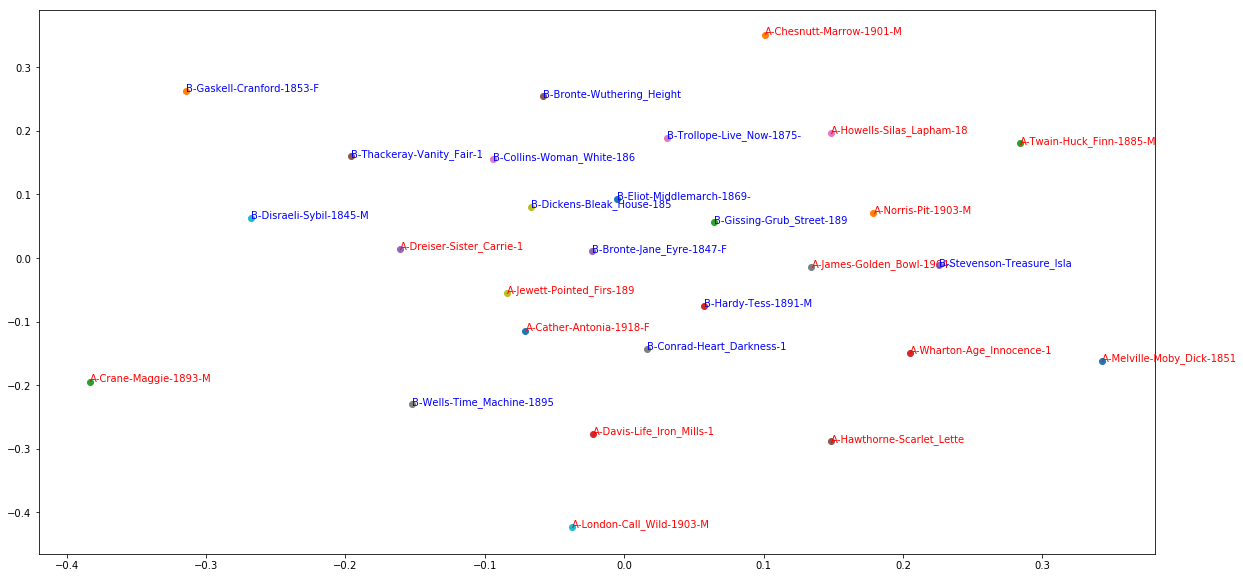

In [41]:
stoplist_vectorizer = TfidfVectorizer(use_idf=False, 
                                      stop_words=stopwords_better,
                                      max_features=5000)
plot_corpus_similarity(corpus, stoplist_vectorizer)

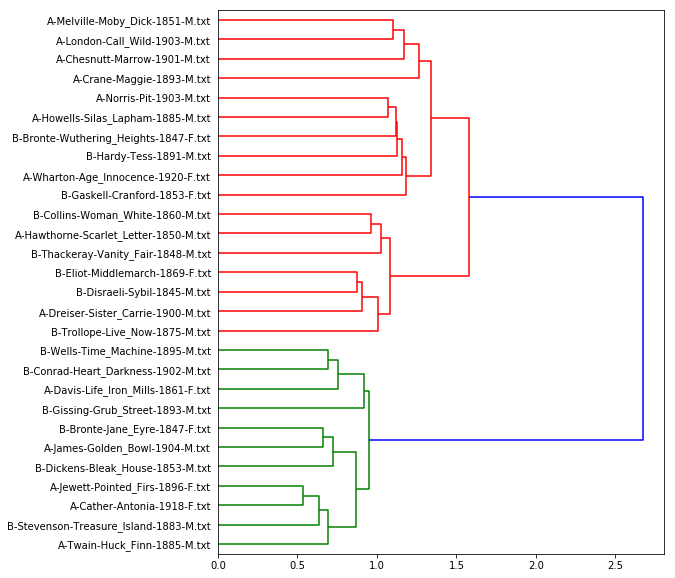

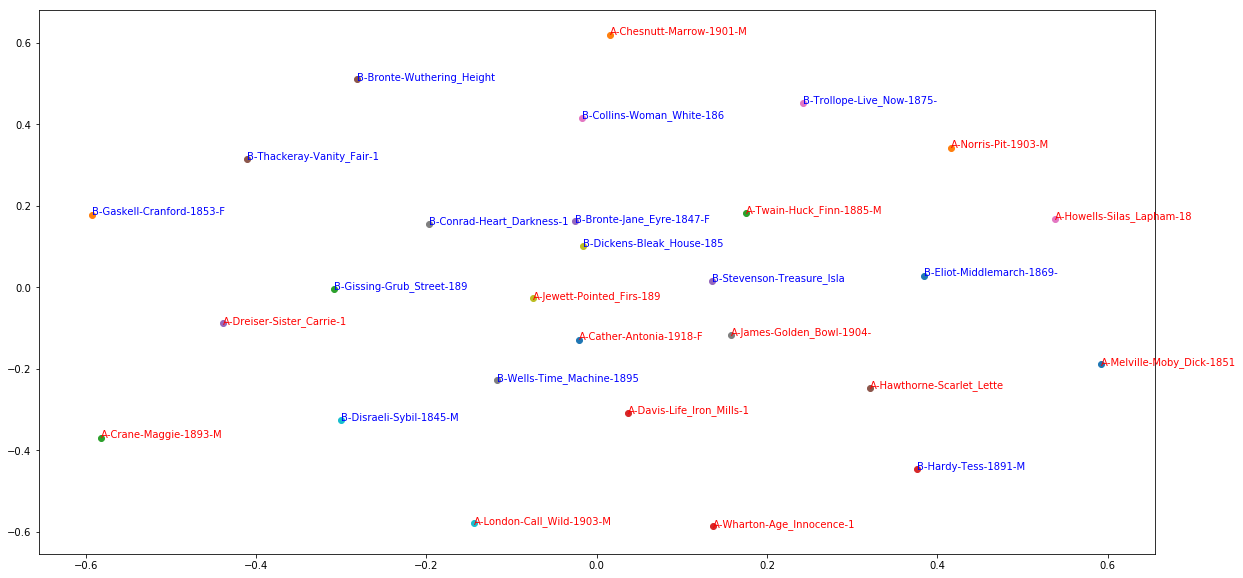

In [43]:
# Use TF-IDF
tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                      stop_words=stopwords_better,
                                      max_features=5000)
plot_corpus_similarity(corpus, tfidf_vectorizer)

## Supervised classification

There are [many, many different classifiers](http://scikit-learn.org/stable/supervised_learning.html) implemented in `scikit-learn`. Here, we compare a few of them over our small corpus, trying to separate British from American-authored novels.

All of these classifers work by combining the input feature weights (here, the counts of the words in each text) to find the line or surface that best divides the two classes. Beyond that, there's a great deal of mathematical detail that we'll elide by simply comparing the accuracy of their outputs on our data. 

In [36]:
import random
from collections import defaultdict
from pandas import DataFrame
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

In [44]:
def benchmark_svms(labelled_texts, runs, vectorizer, categories):
    '''Compare classifiers by averaging accuracy over multiple 50/50 splits of corpus.
       Takes a list of (label, raw_text) tuples, number of runs, NLTK vectorizer, and
          list of (indicator, category name) tuples.
       Prints accuracies and plots same.
       Returns results dataframe.'''
    results = defaultdict(list)
    split = int(len(labelled_texts)/2)
    for i in range(0, runs):
        random.shuffle(labelled_texts)
        train_set, test_set = labelled_texts[split:], labelled_texts[:split]
        train_set_categories = [categories[0][1] if categories[0][0] in category else categories[1][1] for category, text in train_set]
        test_set_categories  = [categories[0][1] if categories[0][0] in category else categories[1][1] for category, text in test_set]
        X_train = vectorizer.fit_transform([text for category, text in train_set])
        X_test = vectorizer.transform([text for category, text in test_set])

        for clf, name in (
                (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
                (Perceptron(n_iter=50), "Perceptron"),
                (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
                (KNeighborsClassifier(n_neighbors=10), "kNN"),
                (LinearSVC(), "LinearSVC"),
                (LinearSVC(loss='squared_hinge', penalty="l2", dual=False, tol=1e-3), "LinearSCV L2"),
                (LinearSVC(loss='squared_hinge', penalty="l1", dual=False, tol=1e-3), "LinearSCV L1"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="l2"), "SGD L2"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="l1"), "SGD L1"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet"), "SGD elasticnet"),
                (NearestCentroid(), "NearestCentroid"),
                (MultinomialNB(alpha=.01), "Naïve Bayes Multinomial"),
                (BernoulliNB(alpha=.01), "Naïve Bayes Bernoulli")):
            clf.fit(X_train, train_set_categories)
            results[name].append(clf.score(X_test, test_set_categories))
    orderedresults = [(name, values) for name, values in results.items()] 
    results_df = DataFrame([values for name,values in orderedresults], 
                           index=[name for name,values in orderedresults])
    summary = DataFrame(results_df.mean(axis=1), columns=['acc'])
    summary['std'] = results_df.std(axis=1)
    print("Ordered averages:")
    print(summary.sort_values('acc', ascending=False))
    results_df.transpose().plot(figsize=(20, 10))
    return results_df

Ordered averages:
                              acc       std
NearestCentroid          0.685714  0.090351
Naïve Bayes Bernoulli    0.678571  0.117851
SGD L1                   0.628571  0.125085
Passive-Aggressive       0.607143  0.084179
SGD L2                   0.600000  0.117610
SGD elasticnet           0.600000  0.090351
Naïve Bayes Multinomial  0.578571  0.118809
LinearSVC                0.571429  0.134687
LinearSCV L2             0.571429  0.134687
Perceptron               0.535714  0.112938
Ridge Classifier         0.514286  0.149830
LinearSCV L1             0.507143  0.118809
kNN                      0.457143  0.096421
CPU times: user 29.8 s, sys: 538 ms, total: 30.3 s
Wall time: 28.1 s


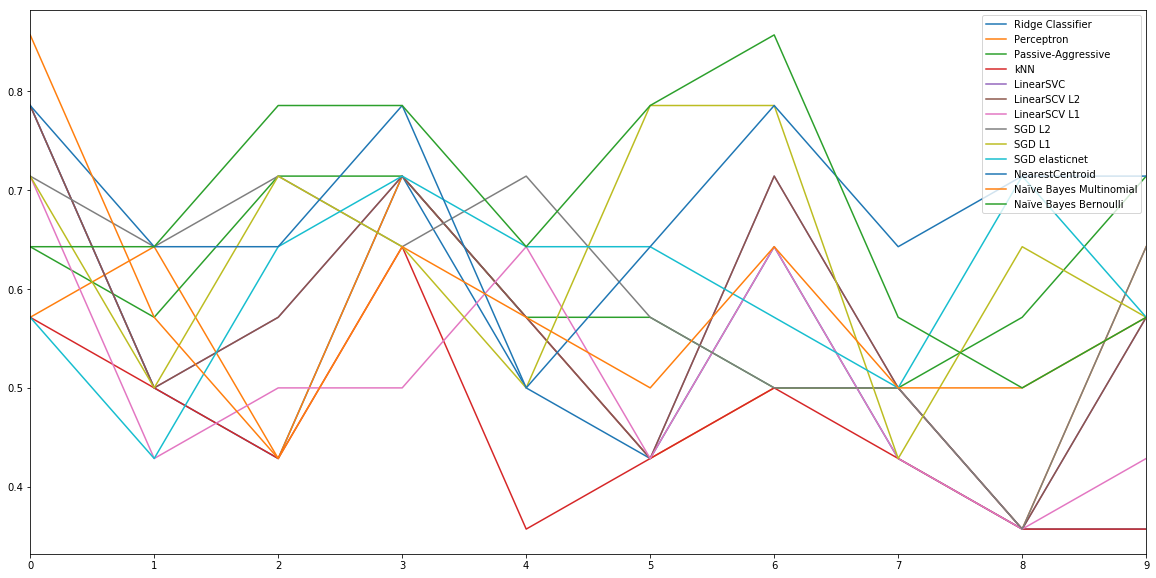

In [45]:
labelled_texts = [(fileid, corpus.raw(fileid)) for fileid in corpus.fileids()]
nation_labels = [('A-', 'American'), ('B-', 'British')]
%time results = benchmark_svms(labelled_texts, 10, stoplist_vectorizer, nation_labels)

### Try classifying author gender

Ordered averages:
                              acc       std
Passive-Aggressive       0.685714  0.090351
Ridge Classifier         0.671429  0.069007
LinearSVC                0.671429  0.069007
LinearSCV L2             0.671429  0.069007
LinearSCV L1             0.671429  0.069007
kNN                      0.664286  0.058805
Naïve Bayes Multinomial  0.664286  0.058805
Perceptron               0.657143  0.073771
SGD L1                   0.628571  0.087805
Naïve Bayes Bernoulli    0.621429  0.067763
SGD L2                   0.614286  0.112687
NearestCentroid          0.614286  0.083842
SGD elasticnet           0.585714  0.120468
CPU times: user 29.9 s, sys: 518 ms, total: 30.4 s
Wall time: 28.1 s


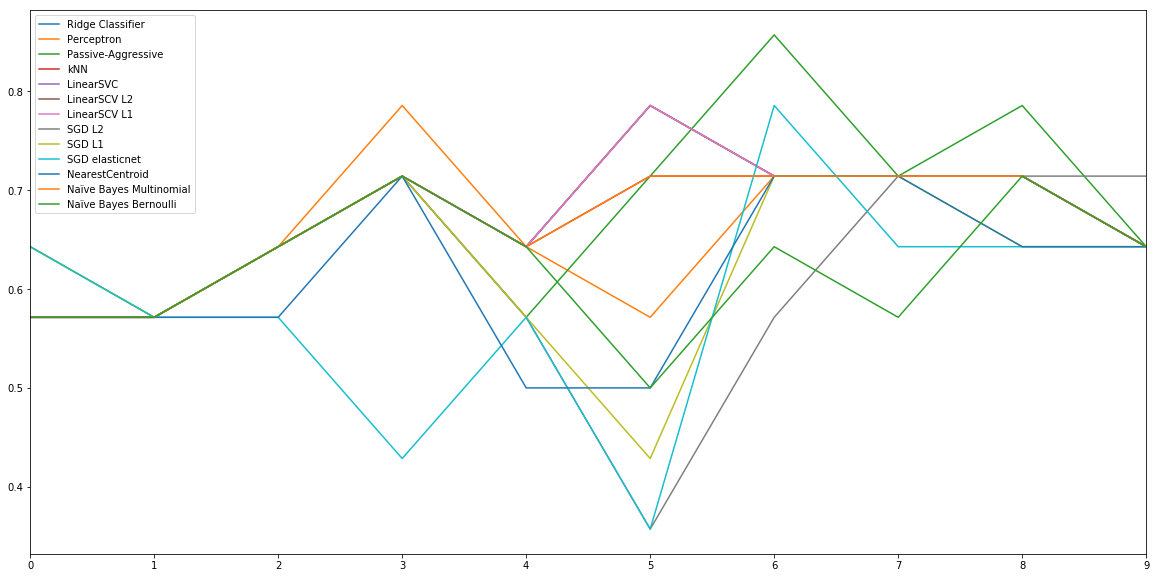

In [46]:
gender_labels = [('-F', 'Female'), ('-M', 'Male')]
%time results = benchmark_svms(labelled_texts, 10, stoplist_vectorizer, gender_labels)

## Predict unseen data

Use a classifier trained on the full toy corpus to predict the nationality of two unseen texts, *Little Women* (American) and *A Room with a View* (British).

In [64]:
X_train = stoplist_vectorizer.fit_transform([corpus.raw(fileid) for fileid in corpus.fileids()])
train_set_categories = ['British' if 'B-' in category else 'American' for category, text in labelled_texts]
#clf = BernoulliNB(alpha=.01)
#clf=NearestCentroid()
#clf=PassiveAggressiveClassifier(n_iter=50)
clf = MultinomialNB(alpha=.01)
clf.fit(X_train, train_set_categories)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [65]:
# Read in test corpus and vectorize
test_dir = "../Data/Test-Texts/"
test_corpus = nltk.corpus.reader.plaintext.PlaintextCorpusReader(test_dir, ".*\.txt")
test_fileids = [fileid for fileid in test_corpus.fileids()]
test_categories = ["British" if "B-" in fileid else "American" for fileid in test_fileids]

X_test = stoplist_vectorizer.transform([test_corpus.raw(fileid) for fileid in test_fileids])
pred = clf.predict(X_test)

In [66]:
for i in range(len(test_fileids)):
    print(test_fileids[i].strip('.txt')) 
    if test_categories[i] == pred[i]:
        print('\t', test_categories[i])
    else:
        print('  ### ERROR ###')
        print('  Actual:   ', test_categories[i])
        print('  Predicted:', pred[i])

A-Alcott-Little_Women-1868-F
	 American
B-Forster-Room_View-1908-M
  ### ERROR ###
  Actual:    British
  Predicted: American


In [67]:
prob = clf.predict_proba(X_test)
for i in range(len(test_fileids)):
    print(test_fileids[i].strip('.txt'))
    print('   Actual:   ', test_categories[i])
    print('   Predicted %:\n\tAmerican', round(prob[i][0]*100, 2), '\tBritish', round(prob[i][1]*100, 2))

A-Alcott-Little_Women-1868-F
   Actual:    American
   Predicted %:
	American 71.73 	British 28.27
B-Forster-Room_View-1908-M
   Actual:    British
   Predicted %:
	American 74.69 	British 25.31
